In [1]:
from word2vec.Word2Vec import studentFeedbackWord2Vec

w2v_skipgram = studentFeedbackWord2Vec()
w2v_skipgram.load("word2vec/skipgram_model.bin")

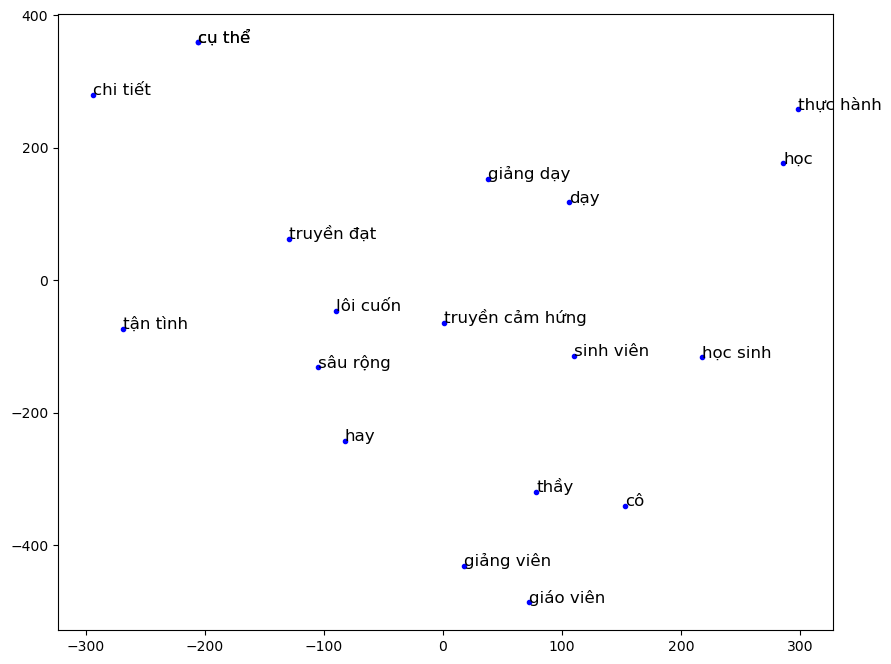

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Chọn các từ bạn muốn vẽ
selected_words = ["thầy","giảng viên", "giáo viên", "cô",
                  "học", "thực hành", 
                  "giảng dạy", "dạy", "truyền đạt", 
                  "sinh viên", "học sinh", 
                  "lôi cuốn", "truyền cảm hứng", "hay", "sâu rộng", 
                  "chi tiết", "tận tình", "cụ thể", "cụ thể"]

# Lấy vector của các từ từ mô hình
vectors = np.array([w2v_skipgram.get_vector(word) for word in selected_words])

# Giảm chiều dữ liệu về 2 chiều bằng t-SNE
tsne = TSNE(n_components=2, perplexity=5 ,random_state=42)
vectors_2d = tsne.fit_transform(vectors)

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], marker='.', color='b')

# Hiển thị tên của các từ
for i, word in enumerate(selected_words):
    plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=12)

plt.show()

In [1]:
from keras.models import load_model

# Assuming you have trained and saved your model as follows
# model.save("models/lstm_model.h5")

# Now, to load the model for later use
loaded_model = load_model("models/lstm_model.keras")

loaded_model.save("models/lstm_model.h5")

/Users/mac/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
from keras.models import load_model

# Assuming you have trained and saved your model as follows
# model.save("models/lstm_model.h5")

# Now, to load the model for later use
loaded_model = load_model("models/lstm_model.h5")

In [14]:
import pickle
from underthesea import word_tokenize
from utils.preprocessing import remove_punctuation
import numpy as np

with open("utils/words_dict.pkl", "rb") as file:
    words = pickle.load(file)

desired_sequence_length = 205


def tokenize_vietnamese_sentence(sentence):
    return word_tokenize(remove_punctuation(sentence.lower()))

def sent2vec(message, word_dict = words):
    tokens = tokenize_vietnamese_sentence(message)
    vectors = []
    
    for token in tokens:
        if token not in word_dict.keys():
            continue
        token_vector = word_dict[token]
        vectors.append(token_vector)
    return np.array(vectors, dtype=float)

def pad_sequence_sentence(sentence):
    array = sent2vec(sentence)
    arr_seq_len = array.shape[0]
    sequence_length_difference = desired_sequence_length - arr_seq_len
        
    pad = np.zeros(shape=(sequence_length_difference, 200))

    array = np.array(np.concatenate([array, pad]))
    array = np.expand_dims(array, axis=0)
    return array

In [15]:
import pandas as pd
from utils.classify import feedbackSentimentAnalysis
from utils.preprocessing import readData

def predictions(file_path):
    sentences = readData(file_path)
    result = []
    for sentence in sentences:
        array = pad_sequence_sentence(sentence)
        percentages = loaded_model.predict(array)
        status_label = np.argmax(percentages)
        result.append(status_label)
    
    sentiments = [feedbackSentimentAnalysis(label) for label in result]
    df = pd.DataFrame({
        "feedback" : sentences,
        "sentiment" : sentiments
    })
    return df

In [16]:
df = predictions("Data/test.txt")

1/1 [==============================] - 0s 35ms/step


In [17]:
df

feedback sentiment
0    cô dạy rất là nhiệt tình , dễ tiếp thu không c...  Tích Cực
1     thầy dễ tính thoải mái , vui tính , nhiệt tình .  Tích Cực
2                        giảng viên dễ chịu vui tính .  Tích Cực
3    chưa tận tâm trong giảng dạy , không nghiên cứ...  Tiêu Cực
4                       giảng phần bài tập hơi nhanh .  Tiêu Cực
..                                                 ...       ...
213  giảng viên diễn đạt quá nhanh , lớp thường rất...  Tiêu Cực
214  thầy không cho slide bài giảng cũng không giới...  Tiêu Cực
215  nếu là điểm cố định thì thầy phải cho cơ hội c...  Tiêu Cực
216                          thầy tiếp tục giảng bài .  Tích Cực
217           tài liệu thầy cung cấp đầy đủ , cụ thể .  Tích Cực

[218 rows x 2 columns]

In [21]:
import plotly.subplots as sp
import plotly.graph_objs as go
import matplotlib.pyplot as plt

labels = df["sentiment"].value_counts().index
values = df["sentiment"].value_counts().values
trace = go.Pie(labels=labels, values=values, name="sentiment")

# Create a layout (optional)
layout = go.Layout(title="Sentiment Distribution")

# Create a figure using the trace and layout
fig = go.Figure(data=[trace], layout=layout)

# Display the figure using iplot
fig.show()

In [8]:
from keras.models import load_model
import numpy as np
import pickle
from underthesea import word_tokenize
from utils.preprocessing import remove_punctuation, readData
from copy import deepcopy
from utils.classify import feedbackSentimentAnalysis
import pandas as pd

# Load Model
model = load_model("models/lstm_model.h5")

with open("utils/words_dict.pkl", "rb") as file:
    words = pickle.load(file)

DESIRED_SEQUENCE_LENGTH = 205

def tokenize_vietnamese_sentence(sentence):
    return word_tokenize(remove_punctuation(sentence.lower()))

def sent2vec(message, word_dict = words):
    tokens = tokenize_vietnamese_sentence(message)
    vectors = []
    
    for token in tokens:
        if token not in word_dict.keys():
            continue
        token_vector = word_dict[token]
        vectors.append(token_vector)
    return np.array(vectors, dtype=float)

def X_to_vectors(sentences):
    all_word_vector_sequences = []
    
    for message in sentences:
      message_as_vector_seq = sent2vec(message)
      if message_as_vector_seq.shape[0] == 0:
        message_as_vector_seq = np.zeros(shape=(1, 200))

      all_word_vector_sequences.append(message_as_vector_seq)
    
    return all_word_vector_sequences

def pad_sequences(X, desired_sequence_length=205):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len
    
    pad = np.zeros(shape=(sequence_length_difference, 200))

    X_copy[i] = np.concatenate([x, pad])
  
  return np.array(X_copy).astype(float)

def predictions(file_path, model = model):
    sentences = readData(file_path)
    vectors = X_to_vectors(sentences)
    sequences = pad_sequences(vectors)
    predictions = (model.predict(sequences))
    
    predicted_labels = np.argmax(predictions, axis=1)
    
    sentiments = [feedbackSentimentAnalysis(label) for label in predicted_labels]
    df = pd.DataFrame({
        "feedback" : sentences,
        "sentiment" : sentiments
    })
    return df

In [9]:
df = predictions("Data/testForApp/sents1.txt")
df.head(10)

17/17 [==============================] - 2s 69ms/step


feedback sentiment
0                           giáo trình chưa cụ thể .  Tiêu Cực
1                                   giảng buồn ngủ .  Tiêu Cực
2                     giáo viên vui tính , tận tâm .  Tích Cực
3  giảng viên nên giao bài tập nhiều hơn , chia n...  Tiêu Cực
4  giảng viên cần giảng bài chi tiết hơn , đi sâu...  Tiêu Cực
5  nên có giảng viên nước ngoài dạy để sinh viên ...  Tiêu Cực
6                 nên có bài tập lớn đồ án môn học .  Tiêu Cực
7  giảng viên đảm bảo nội dung học , phân tích gi...  Tích Cực
8  nêu rõ mục tiêu , mục đích môn học để sinh viê...  Tích Cực
9                     có một số vấn đề nói chưa rõ .  Tiêu Cực